# **BREAKOUT Player Implementation**

You can run this code in Google Colab and watch your NN learn to play BreakOut.
I tried to solve and recreate the succes of the famus DQN paper "Playing Atari with Deep Reinforcement Learning" (https://arxiv.org/abs/1312.5602).
However, while doing so I insisted on doing it by myself. So, I was not aware of the Atari env wrappers used by DeepMind and how convenient they are. Also, I was not aware of the Categorical 51 DQN algorithem and how this approach leads to improved stability and performance in reinforcement learning tasks.

The result was me banging my head against the wall, asking myself, "How could this be so hard if somebody already solved this ??".
Well, it could be challenging when you know someone has solved it, but you refuse to learn from their experience and insist on starting from scratch, relying solely on your own logic.

I gained perspective and tried various methods to converge the system to a solution. Experimenting with different reward systems and momentum approaches daily was fun in a frustrating way. I learned a lot and even exposed myself to 'reward models' and 'curiosity models.' But actually opening another code and seeing the solution - that I would not do. At some point I realised I should get off my high horse and learn from other solutions.

When I saw this solution 2 things sturct me -
*   The environment wrappers make the rest of the code so elegant and smooth; I can't believe they were accessible, and I did not use them.
*   The logic behind C51 Categorical DQN is so elegant, simple, and clean.

I know there are more approaches I can learn about and implement, like Proximal Policy Optimization (PPO), and I am excited to keep digging into this field. Maybe now that I have seen this solution in code, I will try to mix it with one of the ideas I had while I was banging my head against the wall. To be continued..

If you are reading this, I hope I am making this field sound clearer, simplified, and approachable while sharing my review. I am open for questions.

The explanation about the Neural network and training process is shared in the file 'Build Neural Network.ipynb.' The explanation about the Atari wrappers is in the file 'Atari Env Wrappers Explained.ipynb.' More files about my attempts will be shared later on.



Credit & Source - the code is from https://wandb.ai/cleanrl/cleanrl.benchmark/runs/2r5fagq8/overview

IMPORTS

In [ ]:
# @title
########################## IMPORTS #########################################
%pip install -U ale_py==0.8.0
%pip install gym[atari,accept-rom-license]
%pip install gymnasium
import numpy as np
import gymnasium
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import argparse
from distutils.util import strtobool
import collections
import numpy as np
import gym
from gym.wrappers import TimeLimit #, Monitor
from gym.spaces import Discrete, Box, MultiBinary, MultiDiscrete, Space
import time
import random
import os

import matplotlib
matplotlib.use('Agg')
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from google.colab.patches import cv2_imshow
import cv2
import copy
!apt-get install -y python-opengl ffmpeg
%pip install pyvirtualdisplay
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers.record_video import RecordVideo
from IPython.display import display, HTML
from IPython.display import clear_output
import io
import base64
%pip install 'shimmy>=0.2.1'
from gym.spaces import Discrete
from torch.distributions.categorical import Categorical
from collections import deque
from gym import spaces
cv2.ocl.setUseOpenCL(False)


Use CPU or GPU as device

In [ ]:
# @title
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using the GPU")

else:
    device = torch.device("cpu")

# Basic Atari env wrappers for DQN implementation

In [3]:
# @title

class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.integers(1, self.noop_max + 1) #pylint: disable=E1101 ####randit --> integers
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)


class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, width=84, height=84, grayscale=True, dict_space_key=None):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        If the environment uses dictionary observations, `dict_space_key` can be specified which indicates which
        observation should be warped.
        """
        super().__init__(env)
        self._width = width
        self._height = height
        self._grayscale = grayscale
        self._key = dict_space_key
        if self._grayscale:
            num_colors = 1
        else:
            num_colors = 3

        new_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(self._height, self._width, num_colors),
            dtype=np.uint8,
        )
        if self._key is None:
            original_space = self.observation_space
            self.observation_space = new_space
        else:
            original_space = self.observation_space.spaces[self._key]
            self.observation_space.spaces[self._key] = new_space
        assert original_space.dtype == np.uint8 and len(original_space.shape) == 3

    def observation(self, obs):
        if self._key is None:
            frame = obs
        else:
            frame = obs[self._key]

        if self._grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(
            frame, (self._width, self._height), interpolation=cv2.INTER_AREA
        )
        if self._grayscale:
            frame = np.expand_dims(frame, -1)

        if self._key is None:
            obs = frame
        else:
            obs = obs.copy()
            obs[self._key] = frame
        return obs


class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[:-1] + (shp[-1] * k,)), dtype=env.observation_space.dtype)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.just_rgb_render()
        self.frames.append(ob)
        #print(ob.shape)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=-1)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

    def count(self):
        frames = self._force()
        return frames.shape[frames.ndim - 1]

    def frame(self, i):
        return self._force()[..., i]

def wrap_atari(env, max_episode_steps=None):
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)

    assert max_episode_steps is None

    return env

def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env


class ImageToPyTorch(gym.ObservationWrapper):
    """
    Image shape to channels x weight x height
    """

    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(old_shape[-1], old_shape[0], old_shape[1]),
            dtype=np.uint8,
        )

    def observation(self, observation):
        return np.transpose(observation, axes=(2, 0, 1))

def wrap_pytorch(env):
    return ImageToPyTorch(env)

# Reference: https://arxiv.org/pdf/1707.06887.pdf
# https://github.com/ShangtongZhang/DeepRL/blob/master/deep_rl/agent/CategoricalDQN_agent.py


# C51 additional wrappers code

In [4]:
# @title

def image_return_distributions(pmfs, x_length, y_length, dpi=100):
    fig, ax = plt.subplots(figsize=(x_length/dpi,y_length/dpi), constrained_layout=True, dpi=100)
    current_palette = sns.color_palette(n_colors=env.action_space.n)
    df = pd.DataFrame(pmfs.T)
    for idx, y in enumerate(df.columns):
        ax.bar(np.linspace(args.v_min, args.v_max, num=args.n_atoms).astype(int), df[y], color=current_palette[idx]) ######## np.int
    ax.set(xlabel='return distribution', ylabel='probs')
    fig.canvas.draw()
    X = np.array(fig.canvas.renderer.buffer_rgba())
    return_distribution_rgb_array = np.array(Image.fromarray(X).convert('RGB'))
    plt.close(fig)
    return return_distribution_rgb_array

def image_q_values(q_values, x_length, y_length, dpi=100):
    fig, ax = plt.subplots(figsize=(x_length/dpi,y_length/dpi), constrained_layout=True, dpi=100)
    df = pd.DataFrame(q_values.T)
    sns.barplot(x=df.index, y=0, data=df, ax=ax)
    ax.set(xlabel='actions', ylabel='q-values')
    fig.canvas.draw()
    X = np.array(fig.canvas.renderer.buffer_rgba())
    # Image.fromarray(X)
    q_value_rgb_array = np.array(Image.fromarray(X).convert('RGB'))
    plt.close(fig)
    return q_value_rgb_array


class QValueAndReturnDistributionVisualizationWrapper(gym.Wrapper):

    def __init__(self, env):
        super().__init__(env)
        self.env.reset()
        self.image_shape = self.env.render(mode="rgb_array").shape
        self.q_values = np.array([[0.,0.,0.,0.]])
        self.return_pmfs = np.zeros((4, 51))
        # self.metadata['video.frames_per_second'] = 60
        self.states = collections.deque(maxlen=3000) ## Personal addition

    def set_q_values(self, q_values,renderme= False):
        self.q_values = q_values
        if renderme :
            self.render()

    def set_return_pmfs(self, return_pmfs):
        self.return_pmfs = return_pmfs

    def just_rgb_render(self , mode="rgb_array"): ## Personal addition
        env_rgb_array = super().render(mode)
        self.states.append(env_rgb_array)

    def render(self, mode="human"):
        if mode=="rgb_array":
            env_rgb_array = super().render(mode)
            self.q_value_rgb_array = image_q_values(
                self.q_values, self.image_shape[1], self.image_shape[0], dpi=100)
            self.return_rgb_array = image_return_distributions(
                self.return_pmfs, self.image_shape[1]*2, self.image_shape[0], dpi=100)
            return np.append(np.append(
                env_rgb_array,
                self.q_value_rgb_array, axis=1), self.return_rgb_array,
                axis=0)
        else:
            super().render(mode)


#Create Args object

In [5]:
# @title
class Args:
    def __init__(self, gym_id="BreakoutNoFrameskip-v4", learning_rate=25e-5, seed=1,
                 total_timesteps=10000000, torch_deterministic=True, cuda=True,
                 prod_mode=False, capture_video=True, wandb_project_name="cleanRL",
                 wandb_entity=None, n_atoms=51, v_min=-10, v_max=10,
                 buffer_size=1000000, gamma=0.99, target_network_frequency=10000,
                 max_grad_norm=0.5, batch_size=32, start_e=1.0, end_e=0.01,
                 exploration_fraction=0.10, learning_starts=80000, train_frequency=4):

        ####
        self.gym_id = "BreakoutNoFrameskip-v4"
        self.learning_rate = 25e-5
        self.seed = 2
        self.total_timesteps = 10000000
        self.torch_deterministic = True
        self.cuda = True
        self.prod_mode = False
        self.capture_video = True
        self.wandb_project_name = "cleanRL"
        self.wandb_entity = None
        self.n_minibatch = 4
        self.num_envs = 8
        self.num_steps = 128
        self.gamma = 0.99
        self.gae_lambda = 0.95
        self.ent_coef = 0.01
        self.vf_coef = 0.5
        self.max_grad_norm = 0.5
        self.clip_coef = 0.1
        self.update_epochs = 4
        self.kle_stop = False
        self.kle_rollback = False
        self.target_kl = 0.03
        self.gae = True
        self.norm_adv = True
        self.anneal_lr = True
        self.clip_vloss = True
        self.batch_size = 32  # Adjusted based on the formula in the first code
        self.n_atoms = 51
        self.v_min = -10  # Added based on the first code
        self.v_max = 10   # Added based on the first code
        self.buffer_size = 1000000  # Added based on the first code
        self.target_network_frequency = 10000  # Added based on the first code
        self.start_e = 1.0  # Added based on the first code
        self.end_e = 0.01  # Added based on the first code
        self.exploration_fraction = 0.10  # Added based on the first code
        self.learning_starts = 80000  # Added based on the first code
        self.train_frequency = 4  # Added based on the first code



# Example usage
args = Args()
print(args.gym_id)
if not args.seed:
    args.seed = int(time.time())
args.batch_size = int(args.num_envs * args.num_steps)
args.minibatch_size = int(args.batch_size // args.n_minibatch)

BreakoutNoFrameskip-v4


#Environment Set Up & Seeding

In [ ]:
# @title
# TRY NOT TO MODIFY: setup the environment
experiment_name = f"{args.gym_id}__{args.seed}__{int(time.time())}"
writer = SummaryWriter(f"runs/{experiment_name}")
writer.add_text('hyperparameters', "|param|value|\n|-|-|\n%s" % (
        '\n'.join([f"|{key}|{value}|" for key, value in vars(args).items()])))

# TRY NOT TO MODIFY: seeding
device = torch.device('cuda' if torch.cuda.is_available() and args.cuda else 'cpu')
env = gym.make(args.gym_id)
env = wrap_atari(env)
env = gym.wrappers.RecordEpisodeStatistics(env) # records episode reward in `info['episode']['r']`
if 1 : #args.capture_video:
    #env = QValueAndReturnDistributionVisualizationWrapper(env)
    #env = ProbsVisualizationWrapper(env)
    env = QValueAndReturnDistributionVisualizationWrapper(env)
    #env = Monitor(env, f'videos/{experiment_name}')
env = wrap_pytorch(
    wrap_deepmind(
        env,
        clip_rewards=True,
        frame_stack=True,
        scale=False,
    )
)
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic
env.seed(args.seed)
env.action_space.seed(args.seed)
env.observation_space.seed(args.seed)
# respect the default timelimit
print(env.action_space)
assert isinstance(env.action_space, Discrete), "only discrete action space is supported"


#class ReplayBuffer

In [7]:
# @title
# modified from https://github.com/seungeunrho/minimalRL/blob/master/dqn.py#
class ReplayBuffer():
    def __init__(self, buffer_limit):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append(r)
            s_prime_lst.append(s_prime)
            done_mask_lst.append(done_mask)

        return np.array(s_lst), np.array(a_lst), \
               np.array(r_lst), np.array(s_prime_lst), \
               np.array(done_mask_lst)

#Build ***Neural Network***

In [8]:
# @title
# tricks taken from https://github.com/cpnota/autonomous-learning-library/blob/6d1111afce0d1582de463326f7d078a86e850551/all/presets/atari/models/__init__.py#L16
# apparently matters
class Linear0(nn.Linear):
    def reset_parameters(self):
        nn.init.constant_(self.weight, 0.0)
        if self.bias is not None:
            nn.init.constant_(self.bias, 0.0)

class Scale(nn.Module):
    def __init__(self, scale):
        super().__init__()
        self.scale = scale

    def forward(self, x):
        return x * self.scale

class QNetwork(nn.Module):
    def __init__(self, frames=4, n_atoms=51, v_min=-10, v_max=10):
        super(QNetwork, self).__init__()
        self.n_atoms = n_atoms
        self.atoms = torch.linspace(v_min, v_max, steps=n_atoms).to(device)
        self.network = nn.Sequential(
            Scale(1/255),
            nn.Conv2d(frames, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            Linear0(512, env.action_space.n * n_atoms)
        )

    def forward(self, x):
        x = torch.Tensor(x).to(device)
        return self.network(x)

    def get_action(self, x, action=None):
        logits = self.forward(x)
        # probability mass function for each action
        pmfs = torch.softmax(logits.view(len(x), env.action_space.n, self.n_atoms), dim=2)
        q_values = (pmfs*self.atoms).sum(2)
        if action is None:
            action = torch.argmax(q_values, 1)
        return action, pmfs[torch.arange(len(x)), action], q_values, pmfs


In [9]:
def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope =  (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)

rb = ReplayBuffer(args.buffer_size)
q_network = QNetwork(n_atoms=args.n_atoms, v_min=args.v_min, v_max=args.v_max).to(device)
target_network = QNetwork(n_atoms=args.n_atoms, v_min=args.v_min, v_max=args.v_max).to(device)
target_network.load_state_dict(q_network.state_dict())
optimizer = optim.Adam(q_network.parameters(), lr=args.learning_rate, eps=0.01/args.batch_size)
loss_fn = nn.MSELoss()
print(device.__repr__())
print(q_network)


device(type='cpu')
QNetwork(
  (network): Sequential(
    (0): Scale()
    (1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (4): ReLU()
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=3136, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear0(in_features=512, out_features=204, bias=True)
  )
)


Mount Google Drive

In [21]:
from google.colab import drive
drive.mount('/content/gdrive')
checkpoint_path='/content/gdrive/My Drive/DeepLearning/BreakOut/New/ckpt-{}.pk'

Mounted at /content/gdrive


# **RUN THE GAME**

In [11]:

# TRY NOT TO MODIFY: start the game
obs = env.reset()
episode_reward = 0
for global_step in range(args.total_timesteps): ### One step at a loop
    # ALGO LOGIC: put action logic here
    epsilon = linear_schedule(args.start_e, args.end_e, args.exploration_fraction*args.total_timesteps, global_step) ## Use epsilon greedy policy
    action, pmf, q_values, pmfs = q_network.get_action(obs.reshape((1,)+obs.shape)) ### Ask our Agent what he thinks the next action should be
    action = action.tolist()[0] ## converting a PyTorch tensor to a Python list and then extracting the first and only element from that list
    if args.capture_video:
        env.set_q_values(np.array(q_values.tolist()))
        env.set_return_pmfs(np.array(pmfs.tolist())[0])
    if random.random() < epsilon: ## Use epsilon greedy policy
        action = env.action_space.sample()

    # TRY NOT TO MODIFY: execute the game and log data.
    next_obs, reward, done, info = env.step(action) ## Take action in env ## done = True if life is lost
    episode_reward += reward

    # TRY NOT TO MODIFY: record rewards for plotting purposes
    if 'episode' in info.keys(): ## condition is true when the environment signals the end of an episode (the current step resulted in the end of an episode)
        print(f"global_step={global_step}, episode_reward={info['episode']['r']}")
        writer.add_scalar("charts/episode_reward", info['episode']['r'], global_step)
        writer.add_scalar("charts/epsilon", epsilon, global_step)

    # ALGO LOGIC: training.
    rb.put((obs, action, reward, next_obs, done)) ## Add to replay buffer
    if global_step > args.learning_starts and global_step % args.train_frequency == 0: ## Train every train_frequency
        s_obs, s_actions, s_rewards, s_next_obses, s_dones = rb.sample(args.batch_size)
        with torch.no_grad():
            _, next_pmfs, _, _ = target_network.get_action(s_next_obses) ## Get pmf value for best next possible action
            next_atoms = torch.Tensor(s_rewards).to(device).unsqueeze(-1) + args.gamma * q_network.atoms  * (1 - torch.Tensor(s_dones).to(device).unsqueeze(-1))
            ### if done == 1 then next_atoms = rewards
            # projection
            delta_z = q_network.atoms[1]-q_network.atoms[0] ##Delta of pmfs linspace #self.atoms = torch.linspace(v_min, v_max, steps=n_atoms)
            tz = next_atoms.clamp(args.v_min, args.v_max) # Don't overshoot with next_atoms

            b = (tz - args.v_min)/ delta_z
            l = b.floor().clamp(0, args.n_atoms-1)
            u = b.ceil().clamp(0, args.n_atoms-1)
            # (l == u).float() handles the case where bj is exactly an integer
            # example bj = 1, then the upper ceiling should be uj= 2, and lj= 1
            d_m_l = (u + (l == u).float() - b) * next_pmfs
            d_m_u = (b - l) * next_pmfs
            target_pmfs = torch.zeros_like(next_pmfs)
            for i in range(target_pmfs.size(0)):
                target_pmfs[i].index_add_(0, l[i].long(), d_m_l[i])
                target_pmfs[i].index_add_(0, u[i].long(), d_m_u[i])

        _, old_pmfs, _, _ = q_network.get_action(s_obs, s_actions)
        loss = (-(target_pmfs * old_pmfs.clamp(min=1e-5).log()).sum(-1)).mean()
        # loss = (target_pmfs * (target_pmfs.clamp(min=1e-5).log() - old_pmfs.clamp(min=1e-5).log())).sum(-1).mean()
        writer.add_scalar("losses/td_loss", loss, global_step)

        # optimize the midel
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(list(q_network.parameters()), args.max_grad_norm)
        optimizer.step()

        # update the target network
        if global_step % args.target_network_frequency == 0:
            target_network.load_state_dict(q_network.state_dict())

    # TRY NOT TO MODIFY: CRUCIAL step easy to overlook
    obs = next_obs
    if done:
        # important to note that because `EpisodicLifeEnv` wrapper is applied,
        # the real episode reward is actually the sum of episode reward of 5 lives
        # which we record through `info['episode']['r']` provided by gym.wrappers.RecordEpisodeStatistics
        obs, episode_reward = env.reset(), 0

    ### Save NN weight to google drive
    '''
    if global_step%20000 == 0 :
        torch.save(q_network.state_dict(), checkpoint_path.format(global_step//20000))
        print("saved ckpt",global_step//20000)
    '''

torch.save(q_network.state_dict(), checkpoint_path.format(1))

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


global_step=138, episode_reward=1.0
global_step=325, episode_reward=2.0
global_step=484, episode_reward=1.0
global_step=787, episode_reward=4.0
global_step=1026, episode_reward=3.0
global_step=1214, episode_reward=2.0
global_step=1424, episode_reward=2.0
global_step=1537, episode_reward=0.0
global_step=1753, episode_reward=3.0
global_step=1926, episode_reward=2.0
global_step=2185, episode_reward=3.0
global_step=2298, episode_reward=0.0
global_step=2439, episode_reward=1.0
global_step=2602, episode_reward=1.0
global_step=2717, episode_reward=0.0


KeyboardInterrupt: ignored

Play one round and display the last 3000 states from it

In [12]:
env.reset()
env.states.clear()
while True:

    action, _, _, _ = q_network.get_action(obs.reshape((1,) + obs.shape))
    action = action.tolist()[0]

    next_obs, _, done, _ = env.step(action)

    env.just_rgb_render()
    obs = next_obs

    was_real_done = env.was_real_done
    if  was_real_done :
        break
    if done :
      env.reset()
      print("lost ball")


lost ball
lost ball
lost ball
lost ball


In [13]:
print(len(env.states))

220


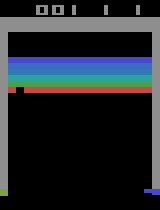

In [14]:
def play_states(states,sec):
    states = np.array(states)
    for i in range(states.shape[0]):
        cv2_imshow(states[i])
        time.sleep(sec)
        clear_output(wait=True)

play_states(env.states,0.1)

Create a video

In [15]:

def creat_video(model,name,env):
    states_tryout = list(env.states)
    image_arrays = np.array(states_tryout)

    # Define the video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    video_writer = cv2.VideoWriter('output_video_{}.mp4'.format(name), fourcc, 60.0, (image_arrays[0].shape[1], image_arrays[0].shape[0]))

    # Write each frame to the video file
    for image_array in image_arrays:
        video_writer.write(image_array)

    # Release the video writer
    video_writer.release()

    # Display the video in Colab
    video_path = 'output_video_{}.mp4'.format(name)
    video_file = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video_file)
    HTML(data='''<video alt="test" controls>
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii')))
    return states_tryout

import os
import glob

def delete_videos_by_name(name_pattern):
    video_files = glob.glob(f'output_video_{name_pattern}.mp4')

    for video_file in video_files:
        try:
            os.remove(video_file)
            print(f"Deleted: {video_file}")
        except OSError as e:
            print(f"Error deleting {video_file}: {e}")

# Replace 'your_name_pattern' with the actual name pattern you want to delete
delete_videos_by_name('your_name_pattern')

In [16]:
states_try = creat_video(q_network,1,env)

Show import and install requirments of the code

In [19]:
%pip list
%pip freeze > requirements.txt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.1
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
ale-py                           0.7.5
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.1.0
audioread                        3.0.1
autograd                         1.6.2
AutoROM                          0.4.2
AutoROM.accept-rom-license       0.6.1
Babel                            2.14.0
bac

Closing and finishing

In [20]:
env.close()
writer.close()